# Transformada Discreta de Fourier - Analizador y Reproductor

La transformada discreta de Fourier permite realizar el análisis espectral de una señal. Nos lleva del espacio de tiempo discreto al espacio de frecuencias, donde podemos obtener información sobre las componentes frecuenciales predominantes de una señal. El desarrollo de este módulo tendrá el siguiente orden:

1. Analizador: toma señales de audio streaming (captura de micrófono) o batch (archivos WAV).
2. Reproductor: Toma archivos con extensión .atm y puede reproducir el audio al mismo tiempo que los gráficos en dominio del tiempo y dominio de frecuencia.

In [1]:
from IPython.display import Image
import numpy as np
import scipy.fftpack as fourier
import matplotlib.pyplot as plt
import scipy.io.wavfile as waves
import winsound

## 1. Analizador de archivos wav

* Cargaremos una grabación de audio .wav (En la carpeta data hay notas de guitarra, SOL, RE, MI, SI).
* Obtendremos la variación temporal de la señal de audio
* Encontraremos la frecuencia dominante y la compararemos con los rangos de frecuencias de las notas musicales


<IPython.core.display.Javascript object>


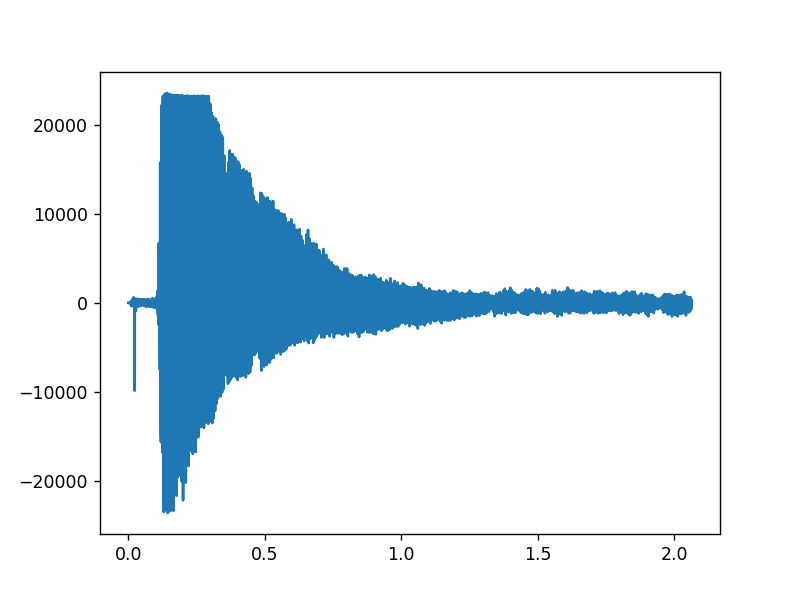

In [13]:
%matplotlib notebook

filename='data/rec_SOL.wav'                                
winsound.PlaySound(filename, winsound.SND_FILENAME)   # Reproducimos el sonido que vamos a cargar

Fs, data = waves.read(filename)                       # Leemos el archivo de audio del directorio
Audio_m = data[:,0]              

L = len(Audio_m)                                      # Tomamos la longitud de la señal

n = np.arange(0,L)/Fs                                 # Definimos un vector de tiempo de la misma longitud de la señal

plt.plot(n,Audio_m)
plt.show()

<IPython.core.display.Javascript object>


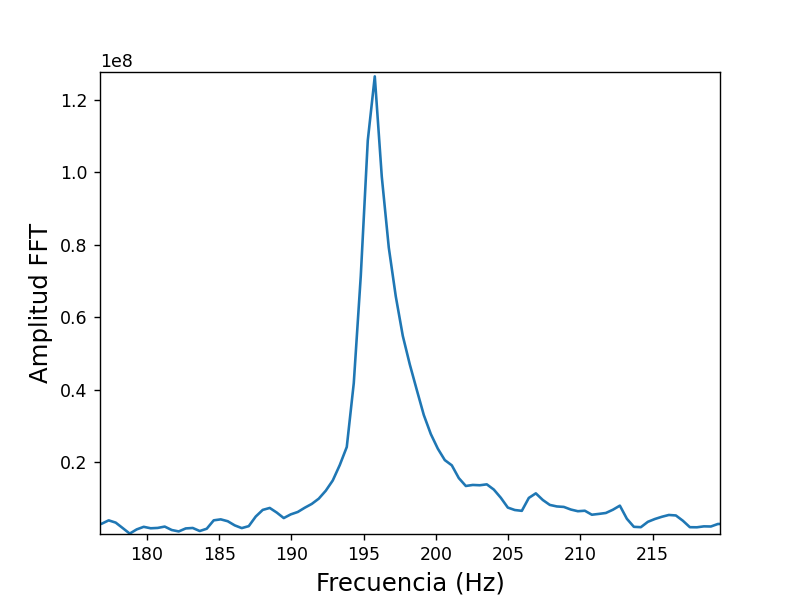

In [14]:
%matplotlib notebook

gk = fourier.fft(Audio_m)                        # Calculamos la FFt de la señal de audio
M_gk = abs(gk)                                   # Tomamos la Magnitud de la FFT
M_gk = M_gk[0:L//2]                              # Tomamos la mitad de los datos (recordar la simetría de la transformada)

Ph_gk = np.angle(gk)
F = Fs*np.arange(0, L//2)/L

plt.plot(F, M_gk)
plt.xlabel('Frecuencia (Hz)', fontsize='14')
plt.ylabel('Amplitud FFT', fontsize='14')
plt.show()

In [4]:
Posm = np.where(M_gk == np.max(M_gk))           # Encontramos la posición para la cual la Magnitud de FFT es máxima
F_fund = F[Posm]                                # Identificamos la Frecuencia asociada al valor del máximo de la Magnitud de FFT

if F_fund > 135 and F_fund < 155:                   # Rango de frecuencias para nota RE
    print("La nota es RE, con frecuencia: ",F_fund)
elif F_fund > 190 and F_fund < 210:                   # Rango de frecuencias para nota SOL
    print("La nota es SOL, con frecuencia: ",F_fund)
elif F_fund > 235 and F_fund < 255:                     # Rango de frecuencias para nota SI
    print("La nota es SI, con frecuencia: ",F_fund)
elif F_fund > 320 and F_fund < 340:                   # Rango de frecuencias para nota MI
    print("La nota es MI, con frecuencia: ",F_fund)

La nota es SOL, con frecuencia:  [195.76740506]


## 1. Analizador de audio streaming (captura de micrófono).

* Instalaremos PyAudio para la adquicisión de audio en tiempo real
* Leemos la señal del micrófono en paquetes de tamaño especificado por el parámetro FRAMES y con frecuencia Fs
* Calculamos la FFT para cada paquete leido, mostramos la gráfica temporal y el espectro de la señal
* Calculamos la Frecuencia Dominante para cada paquete leido

In [5]:
!pip install PyAudio

In [6]:
import matplotlib
import pyaudio as pa 
import struct 
from os import remove
from os import path
from datetime import datetime as dt
import wave
import pyaudio
LARGO_AUDIO=4 #segundos
archivo="output/recorded.wav"
matplotlib.use('TkAgg')
#%matplotlib notebook

FRAMES = 1024*8                                   # Tamaño del paquete a procesar
FORMAT = pa.paInt16                               # Formato de lectura INT 16 bits
CHANNELS = 1
Fs = 44100                                        # Frecuencia de muestreo típica para audio

p = pa.PyAudio()

stream = p.open(                                  # Abrimos el canal de audio con los parámeteros de configuración
    format = FORMAT,
    channels = CHANNELS,
    rate = Fs,
    input=True,
    output=True,
    frames_per_buffer=FRAMES
)

## Creamos una gráfica con 2 subplots y configuramos los ejes

fig, (ax,ax1) = plt.subplots(2)

x_audio = np.arange(0,FRAMES,1)
x_fft = np.linspace(0, Fs, FRAMES)

line, = ax.plot(x_audio, np.random.rand(FRAMES),'r')
line_fft, = ax1.semilogx(x_fft, np.random.rand(FRAMES), 'b')

ax.set_ylim(-5500,5500)      #32500
ax.ser_xlim = (0,FRAMES)

Fmin = 1
Fmax = 1000                  #5000
ax1.set_xlim(Fmin,Fmax)

fig.show()


F = (Fs/FRAMES)*np.arange(0,FRAMES//2)                 # Creamos el vector de frecuencia para encontrar la frecuencia dominante

if path.exists("output/output.txt"):                   # Eliminamos el archivo para no tener datos crusados
    remove('output/output.txt')
					
print("Grabando ...")
frames=[]

timestamp=dt.now()
while (dt.now()-timestamp).seconds<LARGO_AUDIO:
    
    data = stream.read(FRAMES)                         # Leemos paquetes de longitud FRAMES
    dataInt = struct.unpack(str(FRAMES) + 'h', data)   # Convertimos los datos que se encuentran empaquetados en byte
    frames.append(data)
    line.set_ydata(dataInt)                            # Asignamos los datos a la curva de la variación temporal
    
    M_gk = abs(fourier.fft(dataInt)/FRAMES)            # Calculamos la FFT y la Magnitud de la FFT del paqute de datos

    
    ax1.set_ylim(0,np.max(M_gk+10)) 
    line_fft.set_ydata(M_gk)                           # Asigmanos la Magnitud de la FFT a la curva del espectro 
    
    M_gk = M_gk[0:FRAMES//2]                           # Tomamos la mitad del espectro para encontrar la Frecuencia Dominante
    Posm = np.where(M_gk == np.max(M_gk))
    F_fund = F[Posm]                                   # Encontramos la frecuencia que corresponde con el máximo de M_gk
      
    f = open('output/output.txt','a')
    f.write(str(int(F_fund)) + '\n')                   # Escribimos el valor de la frecuencia dominante
    f.close()
    
    #print(int(F_fund))                                 # Imprimimos el valor de la frecuencia dominante

    fig.canvas.draw()
    fig.canvas.flush_events()
    
plt.close()
print("Grabacion a terminado ")

stream.stop_stream()
stream.close()
p.terminate()

waveFile=wave.open(archivo,'wb')
waveFile.setnchannels(1)
waveFile.setsampwidth(p.get_sample_size(pyaudio.paInt16))
waveFile.setframerate(44100)
waveFile.writeframes(b''.join(frames))
waveFile.close()

Grabando ...
Grabacion a terminado 


### Comprimido de las salidas, datos y audio.

In [7]:
import zipfile

try:
    import zlib
    compression = zipfile.ZIP_DEFLATED
except:
    compression = zipfile.ZIP_STORED
    
zf = zipfile.ZipFile("output/atm.zip", mode="w")

try:                                                                # El try es para todo lo que queremos agregar al .zip
    zf.write("output/output.txt", compress_type=compression)        # Agregamos los datos
    zf.write("output/recorded.wav", compress_type=compression)      # Aqui el audio
finally:
    print("zipped in output folder")
    zf.close()
    
if path.exists("output/atm.zip"):          
    remove('output/output.txt')
    remove('output/recorded.wav')

zipped in output folder


## Reproductor

In [8]:
from zipfile import ZipFile

with ZipFile('output/atm.zip', 'r') as zip:
    zip.extractall('data')
    print('File is unzipped in data folder')

File is unzipped in data folder


Obtendremos la variación temporal de la señal de audio

<IPython.core.display.Javascript object>


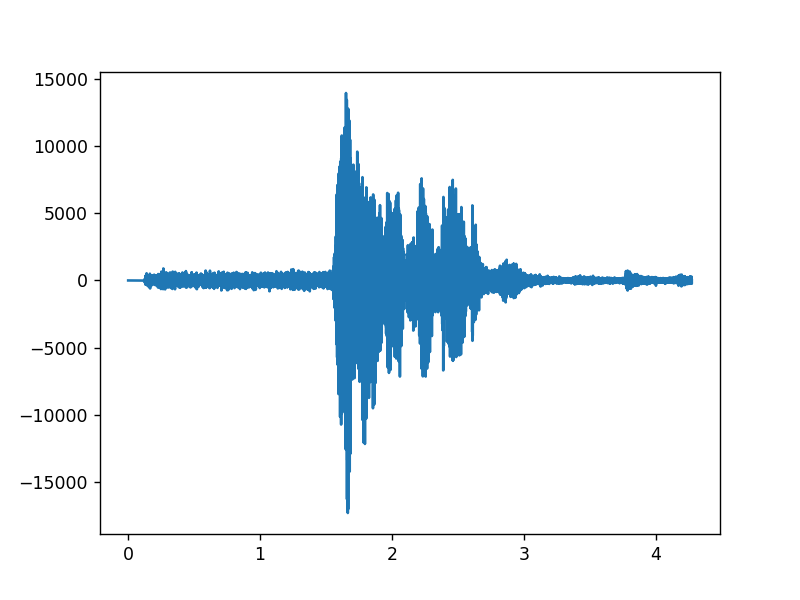

In [15]:
%matplotlib notebook

filename='data/output/rec_esteban/recorded.wav'                                
winsound.PlaySound(filename, winsound.SND_FILENAME)   # Reproducimos el sonido que vamos a cargar

Fs, data = waves.read(filename)                       # Leemos el archivo de audio del directorio
Audio_m = data[:]              

L = len(Audio_m)                                      # Tomamos la longitud de la señal

n = np.arange(0,L)/Fs                                 # Definimos un vector de tiempo de la misma longitud de la señal

plt.plot(n,Audio_m)
plt.show()

Calculamos la FFt de la señal de audio

<IPython.core.display.Javascript object>


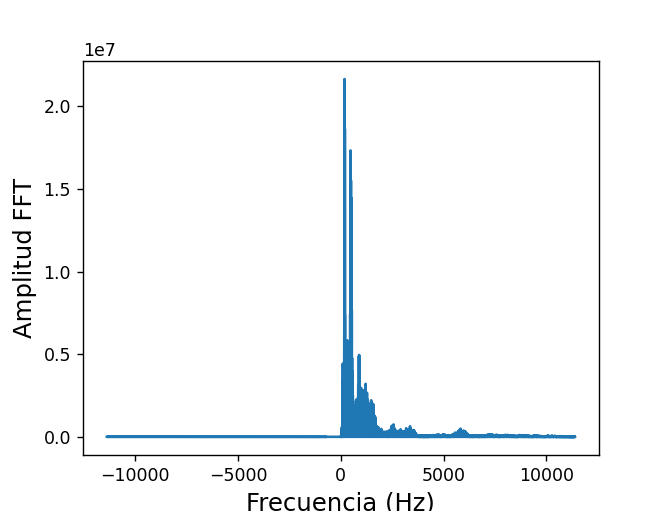

In [16]:
%matplotlib notebook

gk = fourier.fft(Audio_m)                        # Calculamos la FFt de la señal de audio
M_gk = abs(gk)                                   # Tomamos la Magnitud de la FFT
M_gk = M_gk[0:L//2]                              # Tomamos la mitad de los datos (recordar la simetría de la transformada)

Ph_gk = np.angle(gk)
F = Fs*np.arange(0, L//2)/L

plt.plot(F, M_gk)
plt.xlabel('Frecuencia (Hz)', fontsize='14')
plt.ylabel('Amplitud FFT', fontsize='14')
plt.show()